# Промышленность

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Нам предстоит построить модель, которая предскажет температуру стали.

## Цель проекта

Предсказать конечную температуру полного цикла с ошибкой MAE меньше 6.8. Расчитать метрику R*R. Разрешается брать только начальную темпрературу. Обучение модели с кросс-валидацией. Подбор для одной модели гиперпараметров.

## Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc_new.csv` — данные об электродах;
- `data_bulk_new.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time_new.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas_new.csv` — данные о продувке сплава газом;
- `data_temp_new.csv` — результаты измерения температуры;
- `data_wire_new.csv` — данные о проволочных материалах (объём);
- `data_wire_time_new.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

## Откроем файл с данными и изучем общую информацию

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
random_state = 22052023

In [5]:
# Загрузка данных
try:
    arc = pd.read_csv('/datasets/data_arc_new.csv')
    bulk = pd.read_csv('/datasets/data_bulk_new.csv')
    bulk_time = pd.read_csv('/datasets/data_bulk_time_new.csv')
    gas = pd.read_csv('/datasets/data_gas_new.csv')
    temp = pd.read_csv('/datasets/data_temp_new.csv')
    wire = pd.read_csv('/datasets/data_wire_new.csv')
    wire_time = pd.read_csv('/datasets/data_wire_time_new.csv')
except: 
    arc = pd.read_csv('https://code.s3.yandex.net/datasets/data_arc_new.csv')
    bulk = pd.read_csv('https://code.s3.yandex.net/datasets/data_bulk_new.csv')
    bulk_time = pd.read_csv('https://code.s3.yandex.net/datasets/data_bulk_time_new.csv')
    gas = pd.read_csv('https://code.s3.yandex.net/datasets/data_gas_new.csv')
    temp = pd.read_csv('https://code.s3.yandex.net/datasets/data_temp_new.csv')
    wire = pd.read_csv('https://code.s3.yandex.net/datasets/data_wire_new.csv')
    wire_time = pd.read_csv('https://code.s3.yandex.net/datasets/data_wire_time_new.csv')

In [6]:
# Проверка данных
dataframes = [arc, bulk, bulk_time, gas, temp, wire, wire_time]
names = ['arc', 'bulk', 'bulk_time', 'gas', 'temp', 'wire', 'wire_time']

for df, name in zip(dataframes, names):
    print(f'--- {name} ---')
    print(df.head())
    print(df.info())
    print(df.isna().sum())
    print()


--- arc ---
   key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
0    1  2019-05-03 11:02:14  2019-05-03 11:06:02           0.305130   
1    1  2019-05-03 11:07:28  2019-05-03 11:10:33           0.765658   
2    1  2019-05-03 11:11:44  2019-05-03 11:14:36           0.580313   
3    1  2019-05-03 11:18:14  2019-05-03 11:24:19           0.518496   
4    1  2019-05-03 11:26:09  2019-05-03 11:28:37           0.867133   

   Реактивная мощность  
0             0.211253  
1             0.477438  
2             0.430460  
3             0.379979  
4             0.643691  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float

## Предобработке данных

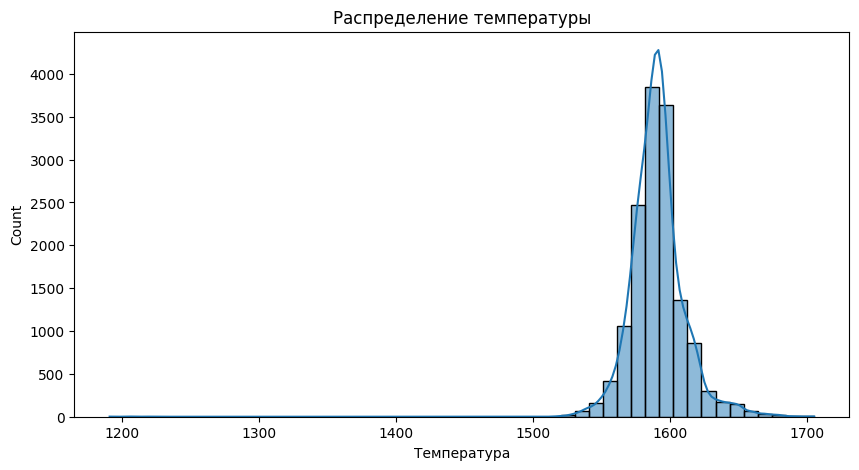

In [12]:
# Анализ распределения температуры
plt.figure(figsize=(10,5))
sns.histplot(temp['Температура'], bins=50, kde=True)
plt.title('Распределение температуры')
plt.show()


In [16]:
arc

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
...,...,...,...,...,...
14871,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579
14872,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543


## Исследовательский анализ данных